# Pricing Test

## Experiment Description
Company XYZ sells a software for \$39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66% of the users have seen the old price (\$39), while a random sample of 33% users a higher price (\$59). The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

## Approach
Two stages of approaches are ran here:
1. A/B Testing
A/B testing can give the significance of the increasing price

    **Null Hypothesis** : The null hypothesis is that this increasing price might lost customers and might not be effective in increasing the revenue.

    ***Alternative Hypothesis*** : The alternative hypothesis is that this might reduce the number of customers who purchase the software, but increasing the overall revenue.
2. Machine Learning Model
Using machine learning model can give the feature, it is done by the decision tree.

## Recommendation


1.   Increase the price from \$39 to \$59 decreases the convertion rate, however, the net revenue will be improved. 
2.   The minimum run time of the experiment is 2 weeks.
3.   Friend referral is the most important for conversion rate, while price does not have a very siginificant impact.





## Data Cleaning

In [142]:
# load modules
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, export_graphviz


In [51]:
# load data
df_results = pd.read_csv('https://github.com/jyan83/Data_Challenges/blob/master/Costly%20Conversion/test_results.csv?raw=true')
df_user = pd.read_csv('https://github.com/jyan83/Data_Challenges/blob/master/Costly%20Conversion/user_table.csv?raw=true')

# join this two tables
df = df_results.set_index('user_id').join(df_user.set_index('user_id'), on = 'user_id')
df.head()

,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
user_id,,,,,,,,,,,
604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [53]:
print('length of data', df.shape[0])
print('unique ids', df.index.nunique())

length of data 316800
unique ids 316800


Does not find duplicate user ids.

In [28]:
# check the control and experiment groups
print(df['test'].value_counts(normalize=True))
df.groupby(['test']).count()

0    0.639921
1    0.360079
Name: test, dtype: float64


,timestamp,source,device,operative_system,price,converted,city,country,lat,long
test,,,,,,,,,,
0,202727,202727,202727,202727,202727,202727,176428,176428,176428,176428
1,114073,114073,114073,114073,114073,114073,99188,99188,99188,99188


The actual percentage of the experiment group is 64\%, slightly smaller than the experiment design value 66\%. There might be some errors in the datasets.

In [29]:
# check the timestamp of the two groups starting from the same day
print('experiment timestamp: ', df[df['test']==1].timestamp.min())
print('control timestamp: ', df[df['test']==0].timestamp.min())

experiment timestamp:  2015-03-02 00:04:12
control timestamp:  2015-03-02 00:12:40


In [30]:
# Add a column of the evaluation metric: net revenue
df['net_revenue'] = df['converted']*df['price']

## Experimental Design
Metric Choice
Invariant Metrics : source.

Evaluation Metrics : conversion, gross revenue, net revenue.

### Measuring Standard Deviation


In [31]:
# Found out the probability of the evalutaion metric
df[df['test']==1].converted.value_counts(normalize=True)
#round(np.sqrt((.36*(1-.36))/(114073)),4)
df[df['test']==1].net_revenue.value_counts(normalize=True)


0     0.984457
59    0.015534
39    0.000009
Name: net_revenue, dtype: float64

In [32]:
# set the creiteris for two groups of dataframe
df_exp = df[(df['test'] == 1) & (df['price'] == 59)]
df_con = df[(df['test'] == 0) & (df['price'] == 39)]

# get the total number of people in the control and experiment group
N_exp = len(df_exp)
N_con = len(df_con)

df_exp.describe()

,test,price,converted,lat,long,net_revenue
count,113918.0,113918.0,113918.000000,99053.000000,99053.000000,113918.000000
mean,1.0,59.0,0.015555,37.138323,-93.974115,0.917748
std,0.0,0.0,0.123747,5.233333,18.076179,7.301050
min,1.0,59.0,0.000000,19.700000,-157.800000,0.000000
25%,1.0,59.0,0.000000,33.660000,-112.200000,0.000000
50%,1.0,59.0,0.000000,37.770000,-89.060000,0.000000
75%,1.0,59.0,0.000000,40.720000,-79.020000,0.000000
max,1.0,59.0,1.000000,61.180000,30.310000,59.000000


In [33]:
df_con.describe()

,test,price,converted,lat,long,net_revenue
count,202517.0,202517.0,202517.000000,176241.000000,176241.000000,202517.000000
mean,0.0,39.0,0.019900,37.097212,-93.985221,0.776083
std,0.0,0.0,0.139656,5.196415,18.092998,5.446566
min,0.0,39.0,0.000000,19.700000,-157.800000,0.000000
25%,0.0,39.0,0.000000,33.660000,-112.240000,0.000000
50%,0.0,39.0,0.000000,37.720000,-88.550000,0.000000
75%,0.0,39.0,0.000000,40.700000,-78.910000,0.000000
max,0.0,39.0,1.000000,61.180000,30.310000,39.000000


## Sanity Check
This check is primarily for the invariant metrics. For invariant metrics we expect equal diversion into the experiment and control group. We will test this at the 95% confidence interval.

In [34]:
# one hot encoding the control table
dummies_source = pd.get_dummies(df_con['source'], prefix= 'source')
#dummies_device = pd.get_dummies(df_con['device'], prefix= 'device')
#dummies_system = pd.get_dummies(df_con['operative_system'], prefix= 'system')
#df_control = pd.concat([df_con, dummies_source, dummies_device, dummies_system], axis=1)
df_control = pd.concat([df_con, dummies_source], axis=1)
df_control.drop(['source', 'device', 'operative_system'], axis=1, inplace=True)
# df_control 

In [35]:
# one hot encoding the experiment table
dummies_source = pd.get_dummies(df_exp['source'], prefix= 'source')
dummies_device = pd.get_dummies(df_exp['device'], prefix= 'device')
dummies_system = pd.get_dummies(df_exp['operative_system'], prefix= 'system')
#df_experiment = pd.concat([df_exp, dummies_source, dummies_device, dummies_system], axis=1)
df_experiment = pd.concat([df_exp, dummies_source], axis=1)

df_experiment.drop(['source', 'device', 'operative_system'], axis=1, inplace=True)
df_experiment  

,timestamp,test,price,converted,city,country,lat,long,net_revenue,source_ads-bing,source_ads-google,source_ads-yahoo,source_ads_facebook,source_ads_other,source_direct_traffic,source_friend_referral,source_seo-bing,source_seo-google,source_seo-other,source_seo-yahoo,source_seo_facebook
user_id,,,,,,,,,,,,,,,,,,,,,
685636,2015-05-07 07:26:01,1,59,0,Fayetteville,USA,35.07,-78.90,0,0,0,0,0,0,1,0,0,0,0,0,0
798371,2015-03-15 08:19:29,1,59,1,East Orange,USA,40.77,-74.21,59,1,0,0,0,0,0,0,0,0,0,0,0
447194,2015-03-28 12:28:10,1,59,0,Dayton,USA,39.78,-84.20,0,0,0,0,1,0,0,0,0,0,0,0,0
431639,2015-04-24 12:42:18,1,59,0,Richmond,USA,37.53,-77.47,0,0,0,0,1,0,0,0,0,0,0,0,0
552048,2015-03-22 08:58:32,1,59,0,Culver City,USA,34.01,-118.40,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190563,2015-05-17 12:03:19,1,59,0,New Haven,USA,41.31,-72.92,0,0,0,0,0,0,0,0,0,0,0,0,1
796427,2015-04-02 09:33:18,1,59,0,Norwalk,USA,33.91,-118.08,0,0,0,0,0,0,0,0,0,1,0,0,0
964001,2015-05-05 13:31:19,1,59,0,Athens-Clarke,USA,33.95,-83.39,0,0,0,0,0,1,0,0,0,0,0,0,0


In [36]:
# count metrics
results = {"Control":pd.Series(df_control.iloc[:, -19:-1].sum(axis=0)),
           "Experiment":pd.Series(df_experiment.iloc[:, -19:-1].sum(axis=0))}
df_results = pd.DataFrame(results)
df_results

,Control,Experiment
price,7898163.00,6721162.00
converted,4030.00,1772.00
lat,6538049.77,3678662.27
long,-16564049.40,-9308417.98
net_revenue,157170.00,104548.00
source_ads-bing,14584.00,8247.00
source_ads-google,37845.00,21497.00
source_ads-yahoo,4812.00,2759.00
source_ads_facebook,34074.00,19281.00
source_ads_other,19256.00,10570.00


In [37]:
# Count Metrics
df_results['Total']=df_results.Control + df_results.Experiment
df_results['Prob'] = 0.36
df_results['StdErr'] = np.sqrt((df_results.Prob * (1- df_results.Prob))/df_results.Total)
df_results["MargErr"] = 1.96 * df_results.StdErr
df_results["CI_lower"] = df_results.Prob - df_results.MargErr
df_results["CI_upper"] = df_results.Prob + df_results.MargErr
df_results["Obs_val"] = df_results.Experiment/df_results.Total
df_results["Pass_Sanity"] = df_results.apply(lambda x: (x.Obs_val > x.CI_lower) and (x.Obs_val < x.CI_upper),axis=1)
df_results['Diff'] = abs((df_results.Experiment - df_results.Control)/df_results.Total)

df_results

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Control,Experiment,Total,Prob,StdErr,MargErr,CI_lower,CI_upper,Obs_val,Pass_Sanity,Diff
price,7898163.00,6721162.00,14619325.00,0.36,0.000126,0.000246,0.359754,0.360246,0.459745,False,0.080510
converted,4030.00,1772.00,5802.00,0.36,0.006302,0.012351,0.347649,0.372351,0.305412,False,0.389176
lat,6538049.77,3678662.27,10216712.04,0.36,0.000150,0.000294,0.359706,0.360294,0.360063,True,0.279874
long,-16564049.40,-9308417.98,-25872467.38,0.36,NaN,NaN,NaN,NaN,0.359781,False,0.280438
net_revenue,157170.00,104548.00,261718.00,0.36,0.000938,0.001839,0.358161,0.361839,0.399468,False,0.201064
source_ads-bing,14584.00,8247.00,22831.00,0.36,0.003177,0.006226,0.353774,0.366226,0.361219,True,0.277561
source_ads-google,37845.00,21497.00,59342.00,0.36,0.001970,0.003862,0.356138,0.363862,0.362256,True,0.275488
source_ads-yahoo,4812.00,2759.00,7571.00,0.36,0.005517,0.010812,0.349188,0.370812,0.364417,True,0.271166
source_ads_facebook,34074.00,19281.00,53355.00,0.36,0.002078,0.004073,0.355927,0.364073,0.361372,True,0.277256
source_ads_other,19256.00,10570.00,29826.00,0.36,0.002779,0.005448,0.354552,0.365448,0.354389,False,0.291222


As seen from the invariant metrics sanity check result table, it can see that most of the source have pass the sanity check, but the device and system are not invariant.

## Result Analysis
Null hypothesis
$H_0: p_{exp}-p_{cont} = 0$

The alternate hypothesis is that
$H_1: p_{exp} - p_{cont} \neq 0$

### Effect Size Tests
95% Confidence interval for the difference between the experiment and control group for evaluation metrics. The result is satistically significant only when the 95% confidence interval does not include zero.

In [90]:
# get the converted results table
df_control_notnull = df_control[pd.isnull(df_control.converted) != True]
df_experiment_notnull = df_experiment[pd.isnull(df_experiment.converted) != True]
df_control_notnull

,timestamp,test,price,converted,city,country,lat,long,net_revenue,source_ads-bing,source_ads-google,source_ads-yahoo,source_ads_facebook,source_ads_other,source_direct_traffic,source_friend_referral,source_seo-bing,source_seo-google,source_seo-other,source_seo-yahoo,source_seo_facebook
user_id,,,,,,,,,,,,,,,,,,,,,
604839,2015-05-08 03:38:34,0,39,0,Buffalo,USA,42.89,-78.86,0,0,0,0,1,0,0,0,0,0,0,0,0
624057,2015-05-10 21:08:46,0,39,0,Lakeville,USA,44.68,-93.24,0,0,0,0,0,0,0,0,0,1,0,0,0
317970,2015-04-04 15:01:23,0,39,0,Parma,USA,41.38,-81.73,0,1,0,0,0,0,0,0,0,0,0,0,0
820854,2015-05-24 11:04:40,0,39,0,Fishers,USA,39.95,-86.02,0,0,0,0,1,0,0,0,0,0,0,0,0
169971,2015-04-13 12:07:08,0,39,0,New York,USA,40.67,-73.94,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680578,2015-04-24 10:13:45,0,39,0,Pasadena,USA,29.66,-95.15,0,0,0,0,0,0,0,0,0,0,0,1,0
17427,2015-04-11 09:29:15,0,39,0,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0
687787,2015-03-16 23:31:55,0,39,0,Bell Gardens,USA,33.97,-118.15,0,0,0,0,0,0,1,0,0,0,0,0,0


In [61]:
# combine the tables
results_notnull = {"Control":pd.Series(df_control.sum(axis=0)),
           "Experiment":pd.Series(df_experiment.sum(axis=0))}
df_results_notnull = pd.DataFrame(results_notnull)
df_results_notnull['Total']=df_results_notnull.Control + df_results_notnull.Experiment
df_results_notnull

,Control,Experiment,Total
timestamp,2015-05-08 03:38:342015-05-10 21:08:462015-04-...,2015-05-07 07:26:012015-03-15 08:19:292015-03-...,2015-05-08 03:38:342015-05-10 21:08:462015-04-...
test,0,113918,113918
price,7898163,6721162,14619325
converted,4030,1772,5802
lat,6.53805e+06,3.67866e+06,1.02167e+07
long,-1.6564e+07,-9.30842e+06,-2.58725e+07
net_revenue,157170,104548,261718
source_ads-bing,14584,8247,22831
source_ads-google,37845,21497,59342
source_ads-yahoo,4812,2759,7571


In [39]:
# define the comparing two models function
def stats_prop(p_hat,z_score,N_cont,N_exp,diff):
    # pooled standard deviations
    std_err = np.sqrt((p_hat * (1- p_hat ))*(1/N_cont + 1/N_exp))
    # margin error
    marg_err = z_score * std_err
    # confidence intervals
    ci_lower = diff - marg_err
    ci_upper = diff + marg_err   
    return std_err,marg_err,ci_lower,ci_upper

For comparing two samples, we calculate the pooled standard error. For e.g., suppose $X_{cont}$ and $N_{cont}$ are the control number of users that click, and the total number of users in the control group. Let $X_{exp}$ and $N_{exp}$ be the values for the experiment. The pooled probability is given by

$\hat{p}_{pool}= \frac{X_{cont}+X_{exp}}{N_{cont}+ N_{test}}$

$SE_{pool} = \sqrt{\hat{p}_{pool}*(1-\hat{p}_{pool})*(\frac{1}{N_{cont}}+\frac{1}{N_{test}})}$

Cohen's d is defined as the difference between two means divided by a standard deviation for the data:

$\hat{d} =\hat{p}_{exp}-\hat{p}_{cont}$

$H_0: d = 0  \text{  where  } \hat{d} \sim N(0,SE_{pool})$

If $\hat{d} > 1.96*SE_{pool}$ or $\hat{d} < -1.96*SE_{pool}$ then we can reject the null hypothesis and state that our difference represents a statistically significant difference

In [72]:
## Comparing two samples
# experimental values
converted_exp = df_results_notnull.loc["converted"].Experiment/N_exp
rev_exp = df_results_notnull.loc["net_revenue"].Experiment/N_exp

# control values
converted_cont = df_results_notnull.loc["converted"].Control/N_con
rev_cont = df_results_notnull.loc["net_revenue"].Control/N_con

# get the differences 
converted_diff = converted_exp - converted_cont
rev_diff = rev_exp - rev_cont
print("Difference of the converted nprobability: ", converted_diff, 
       "Difference of the daily revenue probability: ", rev_diff)

# The pooled probability
Conversion = (converted_exp + converted_cont)/(N_exp + N_con)
NetRevenue = (rev_exp + rev_cont)/(N_exp + N_con)

# Compare two samples
se_Conversion,me_Conversion,cil_Conversion,ciu_Conversion = stats_prop(Conversion, 1.96, N_con, N_exp, converted_diff)
print(se_Conversion,me_Conversion,cil_Conversion,ciu_Conversion)

se_NetRevenue,me_NetRevenue,cil_NetRevenue,ciu_NetRevenue = stats_prop(NetRevenue, 1.96, N_con, N_exp, rev_diff)
print(se_NetRevenue,me_NetRevenue,cil_NetRevenue,ciu_NetRevenue)


Difference of the converted nprobability:  -0.004344515619096384 Difference of the daily revenue probability:  0.14166485821772978
1.2396795237426343e-06 2.429771866535563e-06 -0.00434694539096292 -0.004342085847229848
8.568542166767141e-06 1.6794342646863596e-05 0.1416480638750829 0.14168165256037665


**Practical significance** is the level of change that you would expect to see from a business standpoint for the change to be valuable. What is considered practically significant can vary by field. In medicine, one would expect a 5,10 or 15% improvement for the result to be considered practically significant. At Google, for example, a 1-2% improvement in click through probability is practically significant.

The statistical significance bar is often lower than the practical significance bar, so that if the outcome is practically significance, it is also statistically significant.

<table style="width:100%;">
<colgroup>
<col width="7%" />
<col width="10%" />
<col width="10%" />
<col width="15%" />
<col width="15%" />
<col width="12%" />
</colgroup>
<thead>
<tr class="header">
<th align="center">Metric</th>
<th align="center">Minimum practical significance value</th>
<th align="center">Observed Difference</th>
<th align="center">CI Lower Bound</th>
<th align="center">CI Upper Bound</th>
<th align="center">Result</th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td align="center">Conversion</td>
<td align="center">0.01</td>
<td align="center">-0.0043</td>
<td align="center">-0.004347</td>
<td align="center">-0.004342</td>
<td align="center">Satistically but Not Practically Significant</td>
</tr>
<tr class="even">
<td align="center">Net Revenue</td>
<td align="center">0.02</td>
<td align="center">0.141665</td>
<td align="center">0.141648</td>
<td align="center">0.141682</td>
<td align="center">Statistically and Practically Significant</td>
</tr>
</tbody>
</table>

In the above example, The result is satistically significant only when the 95% confidence interval does not include zero, the null hypothesis is rejected. Since the minimum confidence limit of net revenue is greater than 0 and the practical significance level of 0.02, we conclude that it is highly probable that net revenue is higher than 0.02 and is significant. Based on this, one would increase the software price to \$39.



## Sign Tests
Sign test is just an another method using the day-by-day data to validate the result obtained above. The sensitivity of sign test is lower than that of the above test.

In [41]:
# group timestamp to day
df_SignTest_control = df_control_notnull.groupby(pd.to_datetime(df_control_notnull['timestamp'], errors ='coerce').dt.date).agg({'converted': 'sum', 'net_revenue':'sum', 'test': 'count'}).reset_index()
df_SignTest_experiment = df_experiment_notnull.groupby(pd.to_datetime(df_experiment_notnull['timestamp'], errors ='coerce').dt.date).agg({'converted': 'sum', 'net_revenue':'sum', 'test': 'count'}).reset_index()

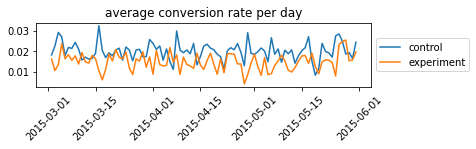

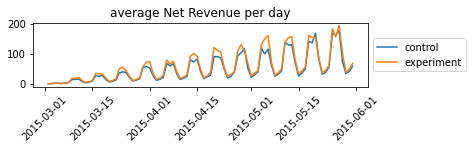

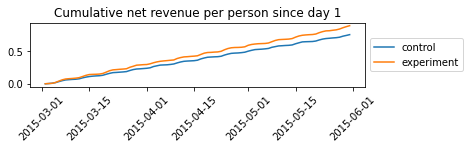

In [42]:
df_control_notnull
# combine the groups for sign test
df_SignTest = pd.merge(df_SignTest_control, df_SignTest_experiment, on="timestamp")
df_SignTest.head()
df_SignTest['Conversion_cont'] = df_SignTest.converted_x/df_SignTest.test_x
df_SignTest['Conversion_exp'] = df_SignTest.converted_y/df_SignTest.test_y
df_SignTest['NetRevenue_cont'] = df_SignTest.net_revenue_x.cumsum()/df_SignTest.test_x
df_SignTest['NetRevenue_exp'] = df_SignTest.net_revenue_y.cumsum()/df_SignTest.test_y
df_SignTest = df_SignTest.fillna(0)

# visualization
plt.clf()
ax = plt.subplot(311)
plt.plot(df_SignTest['timestamp'], df_SignTest['Conversion_cont'], label = 'control')
plt.plot(df_SignTest['timestamp'], df_SignTest['Conversion_exp'], label = 'experiment')
plt.xticks(rotation=45)
plt.title('average conversion rate per day')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

ax = plt.subplot(312)
plt.plot(df_SignTest['timestamp'], df_SignTest['NetRevenue_cont'], label = 'control')
plt.plot(df_SignTest['timestamp'], df_SignTest['NetRevenue_exp'], label = 'experiment')
plt.xticks(rotation=45)
plt.title('average Net Revenue per day')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

ax = plt.subplot(313)
plt.plot(df_SignTest['timestamp'], df_SignTest['NetRevenue_cont']*df_SignTest.test_x/N_con, label = 'control')
plt.plot(df_SignTest['timestamp'], df_SignTest['NetRevenue_exp']*df_SignTest.test_y/N_exp, label = 'experiment')
plt.xticks(rotation=45)
plt.title('Cumulative net revenue per person since day 1')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

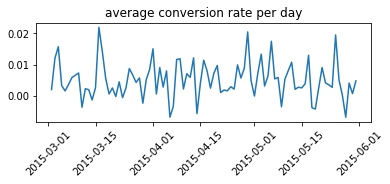

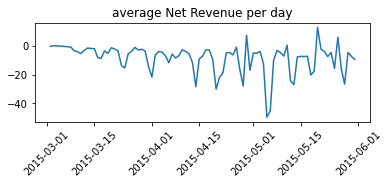

In [43]:
# calculate the sign
df_SignTest['C_Sign'] = df_SignTest.Conversion_cont - df_SignTest.Conversion_exp
df_SignTest['N_Sign'] = df_SignTest.NetRevenue_cont - df_SignTest.NetRevenue_exp

plt.clf()
ax = plt.subplot(211)
plt.plot(df_SignTest['timestamp'], df_SignTest['C_Sign'])
plt.xticks(rotation=45)
plt.title('average conversion rate per day')
plt.show()

ax = plt.subplot(212)
plt.plot(df_SignTest['timestamp'], df_SignTest['N_Sign'])
plt.xticks(rotation=45)
plt.title('average Net Revenue per day')
plt.show()

In [75]:
# Get the statistic values of the sign test
print('Length of days: ', len(df_SignTest))
print('Number of positive conversion rate: ', len(df_SignTest[df_SignTest.C_Sign < 0]))
print('Number of negative net revenue: ', len(df_SignTest[df_SignTest.N_Sign > 0]))


Length of days:  91
Number of positive conversion rate:  13
Number of negative net revenue:  5


Select the significance value $\alpha$ = 0.05. 

In [74]:
stats.binom_test(5, n=91, p=0.5, alternative='two-sided')

3.982648467244083e-20

The p-value is smaller than the alpha level of 0.05. We can reject the null hypothesis and say there is a significant difference.

### How many days you would have stopped the test?
As a rule, you should test for a minimum of seven days, make sure you’ve reached statistical significance, and then test for another seven days if you haven’t, this is also confirmed from the above plots with a weekly cyclic.

In [86]:
# Get the statistic values of the sign test every week
pvalue_table = pd.DataFrame(columns=['weeks', 'p-value'])

for i in range(round(91/7)):
  positive = len(df_SignTest[:i][df_SignTest.N_Sign > 0])
  week_p.append([i, stats.binom_test(positive, n=i*7, p=0.5, alternative='two-sided')])
  pvalue_table = pd.concat([pvalue_table, pd.DataFrame({'weeks': [i], 'p-value': [stats.binom_test(positive, n=i*7, p=0.5, alternative='two-sided')]})])

pvalue_table

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,weeks,p-value
0,0,1.000000e+00
0,1,1.562500e-02
0,2,1.831055e-03
0,3,2.098083e-05
0,4,2.160668e-07
0,5,2.095476e-09
0,6,1.955414e-11
0,7,1.776357e-13
0,8,1.582068e-15
0,9,1.387779e-17


Seen from the p-value starting from the end of second week has a value smaller than the alpha value. Thus, the test can be stopped after 14 days.

## Holistic View of the Feature Importance
Machine learning can be used as a complementary tool for Exploratory Data Analysis (EDA) as well as A/B testing

In [140]:
df_ML = df
# one hot encoding the control table
dummies_source = pd.get_dummies(df_ML['source'], prefix= 'source')
dummies_device = pd.get_dummies(df_ML['device'], prefix= 'device')
dummies_system = pd.get_dummies(df_ML['operative_system'], prefix= 'system')
df_ML = pd.concat([df_ML, dummies_source, dummies_device, dummies_system], axis=1)
df_ML.drop(['timestamp', 'test', 'source', 'city', 'country', 'lat', 'long','device', 'operative_system'], axis=1, inplace=True)
# prepare the training and testing dataset
y = df_ML.loc[:,'converted']
X = df_ML.loc[:, df_ML.columns != 'converted']

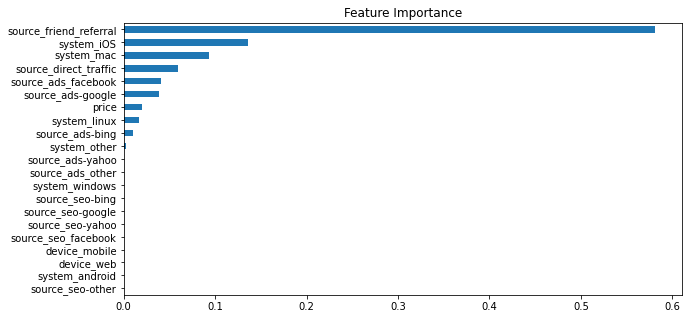

In [160]:
# Select decision tree 
dt = DecisionTreeClassifier(max_depth=4)
# Fit the model
dt.fit(X,y)
export_graphviz(dt, feature_names = X.columns, proportion=True, leaves_parallel=True)
treeimps = pd.Series(dt.feature_importances_,index = X.columns).sort_values(ascending=True)
treeimps.plot(kind='barh',legend=False,title='Feature Importance',figsize=(10,5))


It is seen from the result that friend referral is the most important feature for converted purchase. While price is not as important as much.